In [1]:
import cabinetry

We customize the output from `cabinetry` via a helper function. This is optional, and the `logging` module can be used directly as well to further customize the behavior.

In [2]:
cabinetry.set_logging()

Download a workspace from HEPData, extract it, pick a signal with `pyhf`. We use a workspace from an ATLAS search for bottom-squark pair production: [JHEP 12 (2019) 060](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-31/). The corresponding HEPData entry is [10.17182/hepdata.89408.v3](https://doi.org/10.17182/hepdata.89408.v3).

In [3]:
import json
import pyhf
from pyhf.contrib.utils import download

download("https://www.hepdata.net/record/resource/1935437?view=true", "bottom-squarks")
ws = pyhf.Workspace(json.load(open("bottom-squarks/RegionC/BkgOnly.json")))
patchset = pyhf.PatchSet(json.load(open("bottom-squarks/RegionC/patchset.json")))
ws = patchset.apply(ws, "sbottom_600_280_150")
cabinetry.workspace.save(ws, "bottom-squarks.json")

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.patchset - Validating spec against schema: patchset.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to bottom-squarks.json


The `bottom-squarks.json` workspace is now ready to be used. We will run a maximum likelihood fit with `cabinetry` and visualize the results. First, we have a brief look at the content of the workspace:

In [4]:
!pyhf inspect bottom-squarks.json | head -n 6

                                     Summary       
                               ------------------  
                                  channels  3
                                   samples  9
                                parameters  63
                                 modifiers  63


The fit model specified in the workspace is created next.

In [5]:
ws = cabinetry.workspace.load("bottom-squarks.json")
model, data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier lumi (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CRtt_cuts (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier SigRad (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_SIG (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR (1 new n

We can take a look at a yield table for this model. We first generate the pre-fit model prediction, and then pass it to a function to produce a yield table from it.

In [6]:
model_prefit = cabinetry.model_utils.prediction(model)
cabinetry.tabulate.yields(model_prefit, data)

DEBUG - cabinetry.model_utils - total stdev is [[7.07], [5.02], [4.04, 2.05, 0.964, 0.581]]
DEBUG - cabinetry.model_utils - total stdev per channel is [7.07, 5.02, 5.42]
INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒═════════════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╤═════════════╤═════════════╕
│ sample              │ CRtt_cuts     │ CRz_cuts     │ SR_metsigST   │              │             │             │
│                     │ bin 1         │ bin 1        │ bin 1         │ bin 2        │ bin 3       │ bin 4       │
╞═════════════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╪═════════════╪═════════════╡
│ W                   │ 17.26         │ 0.00         │ 2.16          │ 0.63         │ 0.24        │ 0.42        │
├─────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┼─────────────┼─────────────┤
│ Z                   │ 0.32          │ 53.18        │ 8.77          │ 5.

We can also visualize the pre-fit model prediction and compare it to data. the `visualize.data_mc` function returns a list of dictionaries containing the `matplotlib` figures, which we could use to customize them as needed. We do not need to customize anything here, so we assign the return value to `_`.

DEBUG - cabinetry.visualize.utils - saving figure as figures/CRtt_cuts_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/CRz_cuts_prefit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SR_metsigST_prefit.pdf


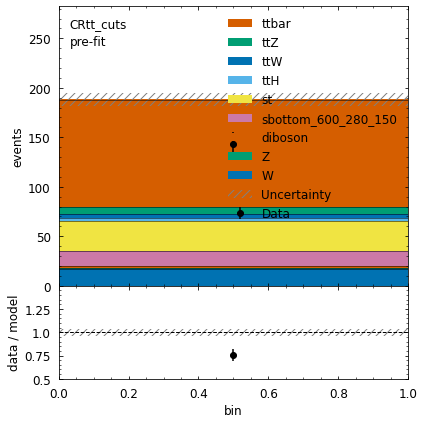

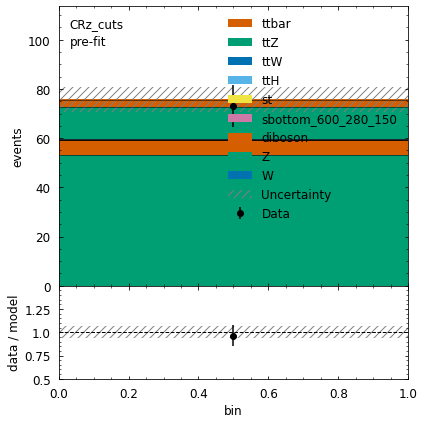

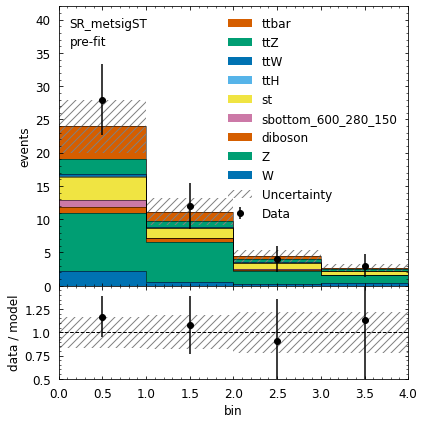

In [7]:
_ = cabinetry.visualize.data_mc(model_prefit, data)

Next up is a maximum likelihood fit:

In [8]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.2                      │             Nfcn = 7415              │
│ EDM = 0.000109 (Goal: 0.0002)    │            time = 1.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

We can now visualize the post-fit distributions. To do so, we need a post-fit model prediction. It is obtained like the pre-fit model prediction, but this time with an additional argument to pass in the fit results.

DEBUG - cabinetry.model_utils - total stdev is [[120], [8.67], [8.46, 1.84, 1.36, 0.597]]
DEBUG - cabinetry.model_utils - total stdev per channel is [120, 8.67, 10.1]
DEBUG - cabinetry.visualize.utils - saving figure as figures/CRtt_cuts_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/CRz_cuts_postfit.pdf
DEBUG - cabinetry.visualize.utils - saving figure as figures/SR_metsigST_postfit.pdf


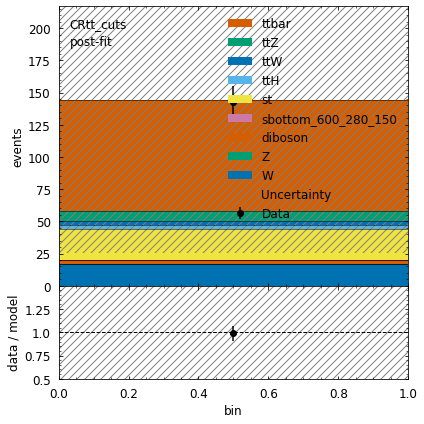

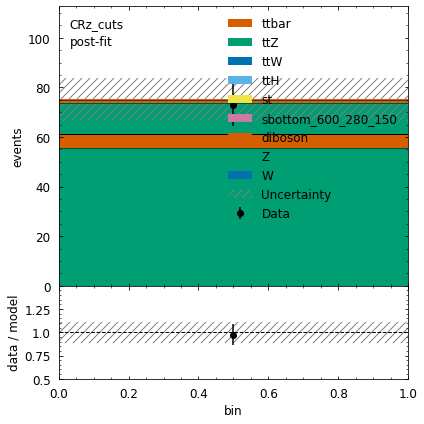

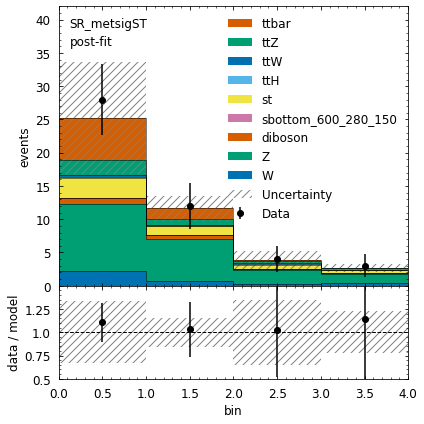

In [9]:
model_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_postfit, data)

The nuisance parameter pulls and correlations are visualized below.

DEBUG - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


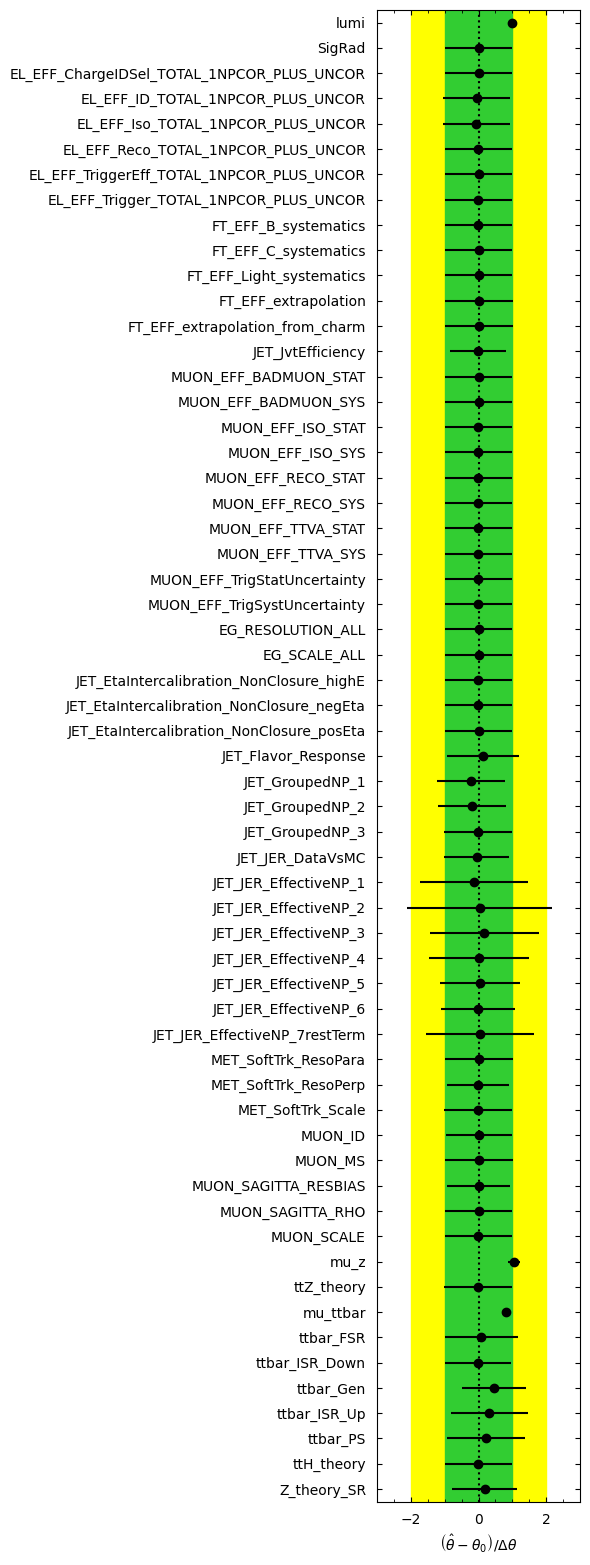

In [10]:
cabinetry.visualize.pulls(fit_results, exclude="mu_SIG")

DEBUG - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


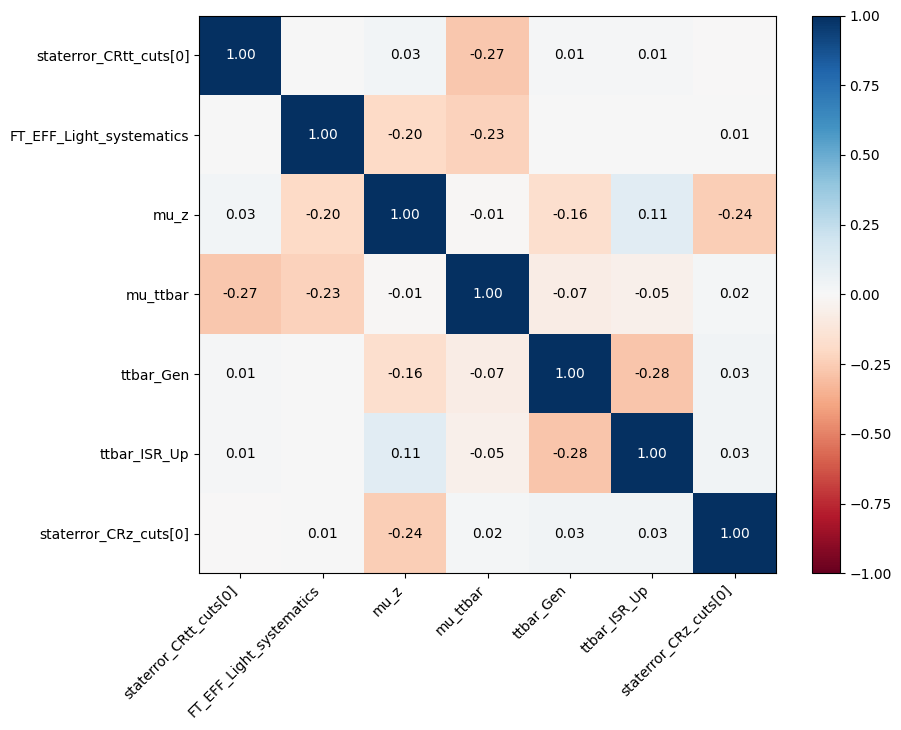

In [11]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)